In [16]:
import numpy as np
import wave
import struct

A=1
fs = 44100
sec = 0.5 #秒
f0=261.626 #ド C4  
f1=293.665 #レ D4  
f2=329.628 #ミ E4  
f3=349.228 #ファ  F   
f4=391.995 #ソ G4  
f5=440.000 #ラ A4  
f6=493.883 #シ B4  
f7=523.251 #ド C5
f_list=(f0,f1,f2,f3,f4,f5,f6,f7)
def create_wave(A,f0,fs,t):
    point = np.arange(0,fs*t)
    sin_wave =A* np.sin(2*np.pi*f0*point/fs)
    sin_wave = [int(x * 32767.0) for x in sin_wave]
    binwave = struct.pack("h" * len(sin_wave), *sin_wave)
    w = wave.Wave_write("./{}.wav".format(f0))
    p = (1, 2, fs, len(binwave), 'NONE', 'not compressed')
    w.setparams(p)
    w.writeframes(binwave)
    w.close()
for i in f_list:
    f=i
    create_wave(A, f, fs, sec)

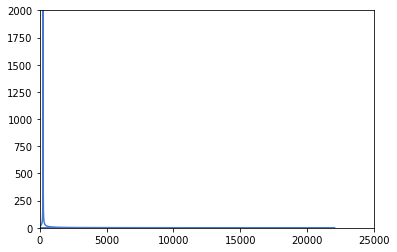

In [44]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack

fname = '261.626.wav'
data, samplerate = sf.read(fname)


X = fftpack.fft(data)
freqList = fftpack.fftfreq(len(data), d=1.0/ samplerate)

amplitude = [np.sqrt(c.real ** 2 + c.imag ** 2) for c in X]  # 振幅スペクトル

# 波形を描画

# 振幅スペクトルを描画
plt.plot(freqList, amplitude)
plt.axis([0, 25000, 0, 2000])
plt.show()